In [3]:
!pip install torch-scatter torch-sparse torch-geometric -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 83.6 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 64.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.6 MB/s eta 0:00:0000:01


In [4]:
import os
import re
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, cohen_kappa_score
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import hstack
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data

nltk.download('punkt')
nltk.download('punkt_tab')

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
warnings.filterwarnings("ignore")

/usr/local/lib/python3.11/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  import torch_geometric.typing
/usr/local/lib/python3.11/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  import torch_geometric.typing


Using device: cuda:0


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


**Preprocessing**

In [5]:
CSV_PATH = '/kaggle/input/bayyin/bayyin_dataset.csv'
ARABERT_PKL_PATH = '/kaggle/input/dataset/train_test_split.pkl'

ARABIC_DIACRITICS = re.compile(r'[\u064B-\u0652]')

def remove_diacritics(text):
    return ARABIC_DIACRITICS.sub('', text)

def remove_non_alpha(text):
    return re.sub(r'[^\w\s]', '', text)

def clean_text(text):
    if pd.isna(text) or not text:
        return ""
    text = str(text).lower()
    text = remove_diacritics(text)
    text = remove_non_alpha(text)
    return re.sub(r'\s+', ' ', text).strip()

def calculate_morph_complexity(tokens_col):
    if pd.isna(tokens_col) or not tokens_col:
        return 1.0
    original_words = tokens_col.split()
    total_morph_units = 0
    total_words = 0
    for word in original_words:
        morph_units = word.count('+') + 1
        total_morph_units += morph_units
        total_words += 1
    return total_morph_units / total_words if total_words > 0 else 1.0

try:
    df = pd.read_csv(CSV_PATH)
    
    # Data Cleaning
    df.dropna(subset=['Sentence', 'Lex', 'Word_Count', 'Readability_Level'], inplace=True)

    # Encode Target
    target_le = LabelEncoder()
    df['Readability_Level_Encoded'] = target_le.fit_transform(df['Readability_Level'])
    
    # Clean Text Column
    df['Clean_Lex'] = df['Lex'].apply(clean_text)
    
except FileNotFoundError:
    print(f"CRITICAL ERROR: CSV file not found at {CSV_PATH}")
    raise

**Feature Engineering**

In [6]:
# --- A. Statistical Features ---
df['Word_Count'] = df['Word_Count'].astype(int)
df['Avg_Lex_Length'] = df['Clean_Lex'].apply(lambda x: np.mean([len(w) for w in x.split()]) if x else 0)
df['Lexical_Density'] = df['Clean_Lex'].apply(lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0)
df['Morph_Complexity'] = df['D3Tok'].apply(calculate_morph_complexity)

X_stats = df[['Word_Count', 'Avg_Lex_Length', 'Lexical_Density', 'Morph_Complexity']].values.astype(np.float64)

# Scale Statistical Features 
scaler = StandardScaler()
X_stats_scaled = scaler.fit_transform(X_stats)

# --- B. TF-IDF Features ---
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Clean_Lex'])

# --- C. Word2Vec Features ---
tokenized_sentences = [word_tokenize(text) for text in df['Sentence'].astype(str)]
w2v_model = Word2Vec(sentences=tokenized_sentences, vector_size=300, window=5, min_count=2, workers=4, sg=1)

def get_avg_vector(tokens, model, vector_size=300):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0: return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

X_w2v = np.array([get_avg_vector(tokens, w2v_model, 300) for tokens in tokenized_sentences])

# --- D. Combine Datasets ---
# Dataset 1: TF-IDF + Stats (Convert sparse TF-IDF to dense for GNN)
X_tfidf_stats = hstack([X_stats_scaled, tfidf_matrix]).toarray()

# Dataset 2: Word2Vec + Stats
X_w2v_stats = np.hstack([X_stats_scaled, X_w2v])

# Labels
y_labels = df['Readability_Level_Encoded'].values

print(f"TF-IDF+Stats Shape: {X_tfidf_stats.shape}")
print(f"Word2Vec+Stats Shape: {X_w2v_stats.shape}")

TF-IDF+Stats Shape: (46410, 5004)
Word2Vec+Stats Shape: (46410, 304)


**GNN Architecture**

In [7]:
class GNNReadabilityGAT(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_classes=6, dropout=0.3):
        super(GNNReadabilityGAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=4, dropout=dropout)
        self.conv2 = GATConv(hidden_dim*4, hidden_dim, heads=4, dropout=dropout)
        self.conv3 = GATConv(hidden_dim*4, hidden_dim, heads=1, dropout=dropout)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.bn1 = nn.BatchNorm1d(hidden_dim*4)
        self.bn2 = nn.BatchNorm1d(hidden_dim*4)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = F.elu(x)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def create_graph_from_features(features, labels, k=10):
    """ Builds a k-NN graph using cosine similarity """
    if not isinstance(features, torch.Tensor):
        x_tensor = torch.tensor(features, dtype=torch.float)
    else:
        x_tensor = features
    y_tensor = torch.tensor(labels, dtype=torch.long)

    # k-NN Graph Construction
    nbrs = NearestNeighbors(n_neighbors=k, metric='cosine').fit(features)
    distances, indices = nbrs.kneighbors(features)
    
    row = np.repeat(np.arange(len(features)), k)
    col = indices.flatten()
    edge_index = torch.tensor([row, col], dtype=torch.long)
    
    data = Data(x=x_tensor, edge_index=edge_index, y=y_tensor)
    return data

def calculate_qwk(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def calculate_adjacency_accuracy(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred) <= 1) / len(y_true)


def run_gnn_experiment(X_features, y_targets, exp_name):
    print(f"\n{exp_name} ")
    if X_features.shape[1] > 1000:
        print("Reducing dimensions from 5004 to 300 using SVD")
        # Use TruncatedSVD (efficient for sparse matrices)
        svd = TruncatedSVD(n_components=300, random_state=42)
        X_features = svd.fit_transform(X_features)
    
        print(f"New Feature Shape: {X_features.shape}")
        print(f"Explained Variance: {svd.explained_variance_ratio_.sum():.2%}")

    # 1. Split Data (Train 70% / Val 10% / Test 20%)
    # First split 80/20 (TrainFull / Test)
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X_features, y_targets, test_size=0.2, random_state=42, stratify=y_targets
    )
    # Then split TrainFull into Train/Val (87.5% / 12.5% of 80% = 70% / 10% total)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.125, random_state=42, stratify=y_train_full
    )

    print(f"Data Splits: Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    
    # 2. Build Graphs
    train_data = create_graph_from_features(X_train, y_train).to(device)
    val_data = create_graph_from_features(X_val, y_val).to(device)
    test_data = create_graph_from_features(X_test, y_test).to(device)

    # 3. Initialize Model
    input_dim = X_features.shape[1]
    model = GNNReadabilityGAT(input_dim=input_dim, hidden_dim=256, num_classes=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    # 4. Training Loop
    best_val_acc = 0
    patience = 15
    patience_counter = 0
    # Sanitize filename
    safe_name = exp_name.replace(" ", "").replace("+", "_")
    best_model_path = f'best_gnn_{safe_name}.pt'
    
    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        out = model(train_data.x, train_data.edge_index)
        loss = criterion(out, train_data.y)
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            out_val = model(val_data.x, val_data.edge_index)
            pred_val = out_val.argmax(dim=1)
            acc_val = (pred_val == val_data.y).sum().item() / len(val_data.y)
            
        if acc_val > best_val_acc:
            best_val_acc = acc_val
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"    Early stopping at Epoch {epoch+1}")
            break

    # 5. Evaluation
    print("Evaluating Best Model")
    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    with torch.no_grad():
        out_test = model(test_data.x, test_data.edge_index)
        pred_test = out_test.argmax(dim=1)
        
    y_true_test = test_data.y.cpu().numpy()
    y_pred_test = pred_test.cpu().numpy()
    
    test_acc = (y_pred_test == y_true_test).sum() / len(y_true_test)
    qwk = calculate_qwk(y_true_test, y_pred_test)
    adj = calculate_adjacency_accuracy(y_true_test, y_pred_test)
    
    print(f"\nResults: {exp_name}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"QWK Score:     {qwk:.4f}")
    print(f"±1 Accuracy:  {adj:.4f}")
    print("\nClassification Report:")
    
    print(classification_report(y_true_test, y_pred_test, digits=4))
    
    cm = confusion_matrix(y_true_test, y_pred_test)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(6, 5))
    class_labels = [1, 2, 3, 4, 5, 6]
    sns.heatmap(
        cm_norm, 
        annot=True, 
        fmt='.2f', 
        cmap='Blues',
        xticklabels=class_labels,  # Set X-axis labels to 1-6
        yticklabels=class_labels   # Set Y-axis labels to 1-6
    )
    plt.title(f'Confusion Matrix: {exp_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

**TF-IDF + Stats model**


TF-IDF + Stats 
Reducing dimensions from 5004 to 300 using SVD
New Feature Shape: (46410, 300)
Explained Variance: 86.73%
Data Splits: Train: 32487, Val: 4641, Test: 9282
    Early stopping at Epoch 18
Evaluating Best Model

Results: TF-IDF + Stats
Test Accuracy: 0.3314
QWK Score:     0.5303
±1 Accuracy:  0.6882

Classification Report:
              precision    recall  f1-score   support

           0     0.5170    0.2553    0.3418      1547
           1     0.3037    0.5734    0.3970      1547
           2     0.2259    0.0349    0.0605      1547
           3     0.2042    0.0937    0.1285      1547
           4     0.3744    0.5837    0.4562      1547
           5     0.3095    0.4473    0.3658      1547

    accuracy                         0.3314      9282
   macro avg     0.3225    0.3314    0.2916      9282
weighted avg     0.3225    0.3314    0.2916      9282



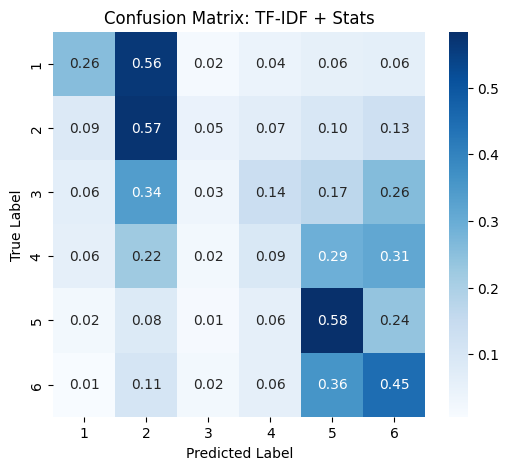

In [12]:
# TF-IDF + Stats
run_gnn_experiment(X_tfidf_stats, y_labels, "TF-IDF + Stats")

**Word2Vec + Stats model**


Word2Vec + Stats 
Data Splits: Train: 32487, Val: 4641, Test: 9282
Evaluating Best Model

Results: Word2Vec + Stats
Test Accuracy: 0.4419
QWK Score:     0.6266
±1 Accuracy:  0.7322

Classification Report:
              precision    recall  f1-score   support

           0     0.5265    0.5268    0.5267      1547
           1     0.4401    0.4389    0.4395      1547
           2     0.3140    0.4480    0.3692      1547
           3     0.4187    0.1532    0.2243      1547
           4     0.5108    0.4286    0.4661      1547
           5     0.4788    0.6561    0.5536      1547

    accuracy                         0.4419      9282
   macro avg     0.4481    0.4419    0.4299      9282
weighted avg     0.4481    0.4419    0.4299      9282



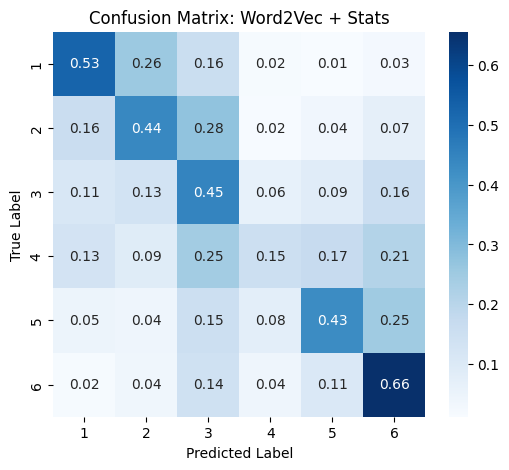

In [13]:
# Word2Vec + Stats 
run_gnn_experiment(X_w2v_stats, y_labels, "Word2Vec + Stats")

**AraBERT Embeddings model**


AraBERT Embeddings 
Data Splits: Train: 32487, Val: 4641, Test: 9282
    Early stopping at Epoch 38
Evaluating Best Model

Results: AraBERT Embeddings
Test Accuracy: 0.5338
QWK Score:     0.7540
±1 Accuracy:  0.8083

Classification Report:
              precision    recall  f1-score   support

           0     0.5469    0.7731    0.6406      1547
           1     0.4867    0.5307    0.5077      1547
           2     0.3841    0.3685    0.3761      1547
           3     0.4404    0.1933    0.2686      1547
           4     0.5777    0.5837    0.5807      1547
           5     0.6932    0.7537    0.7222      1547

    accuracy                         0.5338      9282
   macro avg     0.5215    0.5338    0.5160      9282
weighted avg     0.5215    0.5338    0.5160      9282



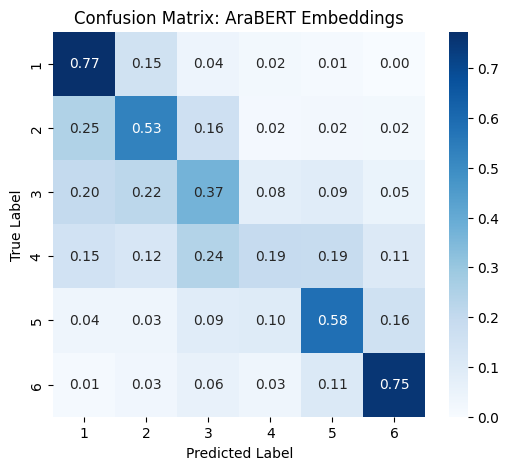

In [8]:
# AraBERT Embeddings

loaded_data = joblib.load(ARABERT_PKL_PATH)

# Handle possible formats from the loaded pickle
if isinstance(loaded_data, tuple):
    if len(loaded_data) == 4:
         X_train_ara, X_test_ara, y_train_ara, y_test_ara = loaded_data
    elif len(loaded_data) == 2:
         (X_train_ara, y_train_ara), (X_test_ara, y_test_ara) = loaded_data
elif isinstance(loaded_data, dict):
    X_train_ara = loaded_data.get('train_embeddings') or loaded_data.get('X_train')
    y_train_ara = loaded_data.get('train_labels') or loaded_data.get('y_train')
    X_test_ara = loaded_data.get('test_embeddings') or loaded_data.get('X_test')
    y_test_ara = loaded_data.get('test_labels') or loaded_data.get('y_test')

# Recombine for uniform GNN splitting
X_arabert_full = np.vstack((X_train_ara, X_test_ara))
y_arabert_full = np.concatenate((y_train_ara, y_test_ara))

# Run Experiment
run_gnn_experiment(X_arabert_full, y_arabert_full, "AraBERT Embeddings")

In [9]:
import os
import shutil
from IPython.display import FileLink, display

# 1. Identify the original model file (generated by your training function)
# Based on your experiment name "AraBERT Embeddings"
original_filename = 'best_gnn_AraBERTEmbeddings.pt'
pkl_filename = 'gnn_arabert_model.pkl'

# Check if the model exists first
if os.path.exists(original_filename):
    # 2. Create a copy with the .pkl extension
    shutil.copy(original_filename, pkl_filename)
    
    print("Success! Both files are ready for download:")
    print("-" * 30)
    
    # 3. Display clickable download links for both
    print(f"1. Standard PyTorch format (.pt):")
    display(FileLink(original_filename))
    
    print(f"2. Pickle format (.pkl):")
    display(FileLink(pkl_filename))
else:
    print(f"Error: Could not find '{original_filename}'.")
    print("Make sure you have run the 'run_gnn_experiment' cell completely.")

Success! Both files are ready for download:
------------------------------
1. Standard PyTorch format (.pt):


/kaggle/working/best_gnn_AraBERTEmbeddings.pt

2. Pickle format (.pkl):


/kaggle/working/gnn_arabert_model.pkl